# Selecting data & finding the most common complaint type

## Install

In [1]:
SYFT_VERSION = ">=0.8.2.b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
# %pip install {package_string} -f https://whls.blob.core.windows.net/unstable/index.html -q

In [2]:
import syft as sy
sy.requires(SYFT_VERSION)

✅ The installed version of syft==0.8.2b2 matches the requirement >=0.8.2b0 and the requirement <0.9


In [3]:
node = sy.orchestra.launch(name="pandas-test-domain-2", port=9082, reset=True)

Starting pandas-test-domain-2 server on 0.0.0.0:9082


Waiting for server to start Done.


# Data Owner: Upload data

In [4]:
domain_client = node.login(email="info@openmined.org", password="changethis")

Logged into pandas-test-domain-2 as <info@openmined.org>


In [5]:
from syft.serde.mock import CachedFaker
from random import randint
from syft.util.util import PANDAS_DATA
from syft.service.project.project import Project
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

plt.rcParams['figure.figsize'] = (15, 5)

## Load data

We're going to use a new dataset here, to demonstrate how to deal with larger datasets. This is a subset of the of 311 service requests from NYC Open Data.

In [7]:
# because of mixed types we specify dtype to prevent any errors
complaints = pd.read_csv(sy.autocache(f"{PANDAS_DATA}/311-service-requests.csv"), dtype='unicode')

Depending on your pandas version, you might see an error like "DtypeWarning: Columns (8) have mixed types". This means that it's encountered a problem reading in our data. In this case it almost certainly means that it has columns where some of the entries are strings and some are integers.

For now we're going to ignore it and hope we don't run into a problem, but in the long run we'd need to investigate this warning.

In [8]:
complaints

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,26589651,10/31/2013 02:08:41 AM,NaN,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,11432,90-03 169 STREET,169 STREET,90 AVENUE,91 AVENUE,NaN,NaN,ADDRESS,JAMAICA,NaN,Precinct,Assigned,10/31/2013 10:08:41 AM,10/31/2013 02:35:17 AM,12 QUEENS,QUEENS,1042027,197389,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.70827532593202,-73.79160395779721,"(40.70827532593202, -73.79160395779721)"
1,26593698,10/31/2013 02:01:04 AM,NaN,NYPD,New York City Police Department,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,11378,58 AVENUE,58 AVENUE,58 PLACE,59 STREET,NaN,NaN,BLOCKFACE,MASPETH,NaN,Precinct,Open,10/31/2013 10:01:04 AM,NaN,05 QUEENS,QUEENS,1009349,201984,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.721040535628305,-73.90945306791765,"(40.721040535628305, -73.90945306791765)"
2,26594139,10/31/2013 02:00:24 AM,10/31/2013 02:40:32 AM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,10032,4060 BROADWAY,BROADWAY,WEST 171 STREET,WEST 172 STREET,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,10/31/2013 10:00:24 AM,10/31/2013 02:39:42 AM,12 MANHATTAN,MANHATTAN,1001088,246531,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.84332975466513,-73.93914371913482,"(40.84332975466513, -73.93914371913482)"
3,26595721,10/31/2013 01:56:23 AM,10/31/2013 02:21:48 AM,NYPD,New York City Police Department,Noise - Vehicle,Car/Truck Horn,Street/Sidewalk,10023,WEST 72 STREET,WEST 72 STREET,COLUMBUS AVENUE,AMSTERDAM AVENUE,NaN,NaN,BLOCKFACE,NEW YORK,NaN,Precinct,Closed,10/31/2013 09:56:23 AM,10/31/2013 02:21:10 AM,07 MANHATTAN,MANHATTAN,989730,222727,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.7780087446372,-73.98021349023975,"(40.7780087446372, -73.98021349023975)"
4,26590930,10/31/2013 01:53:44 AM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Condition Attracting Rodents,Vacant Lot,10027,WEST 124 STREET,WEST 124 STREET,LENOX AVENUE,ADAM CLAYTON POWELL JR BOULEVARD,NaN,NaN,BLOCKFACE,NEW YORK,NaN,NaN,Pending,11/30/2013 01:53:44 AM,10/31/2013 01:59:54 AM,10 MANHATTAN,MANHATTAN,998815,233545,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.80769092704951,-73.94738703491433,"(40.80769092704951, -73.94738703491433)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111064,26426013,10/04/2013 12:01:13 AM,10/07/2013 04:07:16 PM,DPR,Department of Parks and Recreation,Maintenance or

## Create Mock data

Let's create the mock data for the complaint dataset.

In [9]:
fake = CachedFaker()

In [10]:
fake_functions = {
    "Unique Key": lambda x: randint(1,1000000),
    "Location": lambda x: (fake.coordinate(), fake.coordinate()),
    "Agency": lambda x: random.choice(["NYPD", "DOHMH", "DPR"]),
    "X Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Y Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Complaint Type": lambda x: random.choice(["Illegal Parking", "Noise - Street/Sidewalk", "'Animal in a Park'"]),
    "Descriptor": lambda x: random.choice([ 'Branch or Limb Has Fallen Down','Branches Damaged','Broken Fence', 'Broken Glass']),
    "School Number": lambda x: random.choice([ 'B073', 'B077', 'B079', 'B080-01', 'B087', 'B099', 'B100', 'B102', 'B109', 'B111']),
    "Bridge Highway Segment": lambda x: random.choice([ 'Grand Central Pkwy (Exit 1 E-W)',
                                                       'Grand Central Pkwy (Exit 10) - 69th Rd-Jewel Ave (Exit 11)',
                                                       'GrandCentral Pkwy/VanWyck Expwy/College Point Blvd (Exit 22 A-E)',
                                                       'Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278) (Exit 1)',
                                                       'Harding Ave (Exit 9) - Throgs Neck Br'])
}

In [11]:
fake_triggers = {
    "Street": lambda x : fake.street_name(),
    "Date": lambda x : fake.date_time(),
    "Long": lambda x : fake.coordinate(),
    "Lat": lambda x : fake.coordinate(),
    "Address": lambda x : fake.address(),
    "Name": lambda x : fake.name(),
    "City": lambda x : fake.city(),
    "Zip": lambda x : fake.zipcode(),
}

In [12]:
mock_data = dict()
for col in complaints.columns:
    col_vals = complaints[col]
    
    if col in fake_functions:
        mock_func = fake_functions[col]
    elif len(set(complaints[col])) < 100:
        values = list(set(complaints[col]))
        mock_func = lambda x: random.choice(values)
    else:
        for trigger in fake_triggers.keys():
            if trigger in col:
                mock_func = fake_triggers[trigger]
    mock_data[col] = [mock_func(None) for x in range(len(complaints))]

In [13]:
mock = pd.DataFrame(data=mock_data)

In [14]:
mock.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,335329,1984-04-02 14:40:10,2001-12-22 10:37:54,DPR,Tiffany Andrews,Noise - Street/Sidewalk,Broken Fence,Speed Reducer,39755,Unit 8481 Box 8652\nDPO AE 05617,Michelle Ferguson,Beck Lane,Tanner Meadows,Cortez Greens,Ryan Mews,NaN,Shannonview,LYONS REC CENTER,DSNY Garage,Assigned,1988-04-27 11:02:58,1992-05-17 02:30:15,01 MANHATTAN,MANHATTAN,31110,687882,Troy Garcia,QUEENS,Rachael Garcia,B099,Region 1,11X513,7186672165,"354 Alexander Trail\nPhillipsport, ME 24045",RIDGEWOOD,NY,58405,NaN,NaN,Ambulette / Paratransit,MANHATTAN,La Guardia Airport,Staten Island Expwy,Northbound,Roadway,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Astoria Field,Manhattan Bound,Kennedy,75.037527,-121.285765,"(-89.482318, 113.150538)"
1,843471,1973-04-16 01:37:55,1982-12-15 03:03:18,DPR,Elizabeth Warner,Noise - Street/Sidewalk,Broken Glass,Residential,10582,Unit 9089 Box 9607\nDPO AA 11236,Elizabeth Warner,Ronald Glen,Jack Circle,Beck Lane,Moore Summit,INTERSECTION,West Kathy,CENTRAL PARK,NaN,Started,2008-09-05 03:40:57,1995-04-12 04:36:58,15 BROOKLYN,BROOKLYN,708768,556024,Jennifer Montgomery,MANHATTAN,Mark Frost,B080-01,Region 4,01M361,7187201010,"22951 Stark Plaza\nMurrayberg, NC 60457",BELLEROSE,NY,58405,NaN,NaN,NaN,BROOKLYN,JFK Airport,Throgs Neck Expwy,West/Staten Island Bound,NaN,Harding Ave (Exit 9) - Throgs Neck Br,SI Ferry Terminal,Staten Island Bound,ELLEN MUSKAT,127.114452,73.919413,"(-162.034749, -107.330551)"
2,468925,2018-11-07 23:21:36,1995-04-12 04:36:58,DPR,Marissa Stewart,Noise - Street/Sidewalk,Broken Fence,Speed Reducer,95085,"95152 Lauren Ports Apt. 572\nNew Loriton, TX 7...",John Garcia,Lisa Prairie,Eric Knoll,Cortez Greens,Frazier Gateway,ADDRESS,West Paul,GRAND ARMY PLAZA,NaN,Pending,1995-01-01 13:01:00,2021-03-27 09:54:19,07 BROOKLYN,MANHATTAN,756952,674474,Ana Porter,Unspecified,Julie Hicks,B111,Region 3,02M001,7186672165,"PSC 1104, Box 2576\nAPO AP 22167",HOLLIS,NY,68769,NaN,NaN,Commuter Van,BROOKLYN,JFK Airport,West Shore Expwy,East Bound,Ramp,Grand Central Pkwy (Exit 1 E-W),Broome and Ludlow Field,Staten Island Bound,MERSEDES LUNA,-94.133551,73.919413,"(-54.769168, -162.034749)"
3,952195,2011-09-06 12:38:25,1976-03-23 21:46:19,DOHMH,Sharon Franklin,Illegal Parking,Broken Glass,Other (Explain Below),81113,461 Rachel Center Suite 156\nNorth Katherinefu...,Nicole Brown,Frazier Gateway,Haney Heights,Mark Isle,Natalie Ford,PLACENAME,New Monique,QUEENS COLLEGE,NaN,Email Sent,1984-07-23 05:12:55,2011-09-06 12:38:25,02 BROOKLYN,Unspecified,768383,581050,Michelle Ferguson,MANHATTAN,Lisa Mclaughlin,B109,Region 7,06M143,2123603444,"83751 Kathryn Points Apt. 431\nJerrybury, KS 4...",NEW YORK,NY,53632,Y,NaN,Ambulette / Paratransit,BROOKLYN,New York-Penn Station,BQE/Gowanus Expwy,North/Bronx Bound,NaN,Grand Central Pkwy (Exit 1 E-W),Flatbush/Caton Field,Staten Island Bound,GAYLORD WHITE SENIOR CENTER,-17.257861,73.919413,"(-107.330551, 111.469701)"
4,629728,1999-12-27 13:07:38,1992-05-17 02:30:15,DOHMH,Tony Weeks,Noise - Street/Sidewalk,Branch or Limb Has Fallen Down,Pool,31812,"42809 Reynolds Islands\nSouth Shannonfurt, MA ...",Whitney Wallace,Andrew Heights,May Curve,Oliver Lodge,Alan Glens,NaN,North Jonathan,BARCLAYS CENTER,NaN,Started,2014-09-27 02:0

In [15]:
dataset = sy.Dataset(name="test",
                     asset_list=[sy.Asset(name="complaints", data=complaints, mock=mock, mock_is_real=False)])
domain_client.upload_dataset(dataset)

  0%|          | 0/1 [00:00<?, ?it/s]

Uploading: complaints


100%|██████████| 1/1 [00:09<00:00,  9.50s/it]

100%|██████████| 1/1 [00:09<00:00,  9.50s/it]

**WARNING**: The total size for asset: 'complaints' exceeds '512 MB'. This might result in failure to upload dataset. Please contact #support on OpenMined slack for further assistance.


<class 'syft.service.response.SyftSuccess'>: Dataset uploaded to 'pandas-test-domain-2'. To see the datasets uploaded by a client on this node, use command `[your_client].datasets`

## Create data scientist

In [16]:
user = domain_client.register(name="Jane Doe", email="jane@caltech.edu",
                            password="abc123", institution="Caltech", website="https://www.caltech.edu/")

# todo: give user data scientist role

guest_domain_client = node.client

guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

Logged into pandas-test-domain-2 as <jane@caltech.edu>


# Data scientist: create syft_function

## Download mock and submit project

### Get mock

In [17]:
guest_domain_client = node.client

In [18]:
# guest_domain_client = worker.guest_client
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

Logged into pandas-test-domain-2 as <jane@caltech.edu>


In [19]:
ds = guest_domain_client.datasets[0]

In [20]:
asset = ds.assets["complaints"]

In [21]:
complaints = asset.mock

### What's even in it? (the summary)


When you print a large dataframe, it will only show you the first few rows.

If you don't see this, don't panic! The default behavior for large dataframes changed between pandas 0.12 and 0.13. Previous to 0.13 it would show you a summary of the dataframe. This includes all the columns, and how many non-null values there are in each column.

In [22]:
complaints

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,335329,1984-04-02 14:40:10,2001-12-22 10:37:54,DPR,Tiffany Andrews,Noise - Street/Sidewalk,Broken Fence,Speed Reducer,39755,Unit 8481 Box 8652\nDPO AE 05617,Michelle Ferguson,Beck Lane,Tanner Meadows,Cortez Greens,Ryan Mews,None,Shannonview,LYONS REC CENTER,DSNY Garage,Assigned,1988-04-27 11:02:58,1992-05-17 02:30:15,01 MANHATTAN,MANHATTAN,31110,687882,Troy Garcia,QUEENS,Rachael Garcia,B099,Region 1,11X513,7186672165,"354 Alexander Trail\nPhillipsport, ME 24045",RIDGEWOOD,NY,58405,None,NaN,Ambulette / Paratransit,MANHATTAN,La Guardia Airport,Staten Island Expwy,Northbound,Roadway,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Astoria Field,Manhattan Bound,Kennedy,75.037527,-121.285765,"[-89.482318, 113.150538]"
1,843471,1973-04-16 01:37:55,1982-12-15 03:03:18,DPR,Elizabeth Warner,Noise - Street/Sidewalk,Broken Glass,Residential,10582,Unit 9089 Box 9607\nDPO AA 11236,Elizabeth Warner,Ronald Glen,Jack Circle,Beck Lane,Moore Summit,INTERSECTION,West Kathy,CENTRAL PARK,None,Started,2008-09-05 03:40:57,1995-04-12 04:36:58,15 BROOKLYN,BROOKLYN,708768,556024,Jennifer Montgomery,MANHATTAN,Mark Frost,B080-01,Region 4,01M361,7187201010,"22951 Stark Plaza\nMurrayberg, NC 60457",BELLEROSE,NY,58405,None,NaN,None,BROOKLYN,JFK Airport,Throgs Neck Expwy,West/Staten Island Bound,None,Harding Ave (Exit 9) - Throgs Neck Br,SI Ferry Terminal,Staten Island Bound,ELLEN MUSKAT,127.114452,73.919413,"[-162.034749, -107.330551]"
2,468925,2018-11-07 23:21:36,1995-04-12 04:36:58,DPR,Marissa Stewart,Noise - Street/Sidewalk,Broken Fence,Speed Reducer,95085,"95152 Lauren Ports Apt. 572\nNew Loriton, TX 7...",John Garcia,Lisa Prairie,Eric Knoll,Cortez Greens,Frazier Gateway,ADDRESS,West Paul,GRAND ARMY PLAZA,None,Pending,1995-01-01 13:01:00,2021-03-27 09:54:19,07 BROOKLYN,MANHATTAN,756952,674474,Ana Porter,Unspecified,Julie Hicks,B111,Region 3,02M001,7186672165,"PSC 1104, Box 2576\nAPO AP 22167",HOLLIS,NY,68769,None,NaN,Commuter Van,BROOKLYN,JFK Airport,West Shore Expwy,East Bound,Ramp,Grand Central Pkwy (Exit 1 E-W),Broome and Ludlow Field,Staten Island Bound,MERSEDES LUNA,-94.133551,73.919413,"[-54.769168, -162.034749]"
3,952195,2011-09-06 12:38:25,1976-03-23 21:46:19,DOHMH,Sharon Franklin,Illegal Parking,Broken Glass,Other (Explain Below),81113,461 Rachel Center Suite 156\nNorth Katherinefu...,Nicole Brown,Frazier Gateway,Haney Heights,Mark Isle,Natalie Ford,PLACENAME,New Monique,QUEENS COLLEGE,None,Email Sent,1984-07-23 05:12:55,2011-09-06 12:38:25,02 BROOKLYN,Unspecified,768383,581050,Michelle Ferguson,MANHATTAN,Lisa Mclaughlin,B109,Region 7,06M143,2123603444,"83751 Kathryn Points Apt. 431\nJerrybury, KS 4...",NEW YORK,NY,53632,Y,NaN,Ambulette / Paratransit,BROOKLYN,New York-Penn Station,BQE/Gowanus Expwy,North/Bronx Bound,None,Grand Central Pkwy (Exit 1 E-W),Flatbush/Caton Field,Staten Island Bound,GAYLORD WHITE SENIOR CENTER,-17.257861,73.919413,"[-107.330551, 111.469701]"
4,629728,1999-12-27 13:07:38,1992-05-17 02:30:15,DOHMH,Tony Weeks,Noise - Street/Sidewalk,Branch or Limb Has Fallen Down,Pool,31812,"42809 Reynolds Islands\nSouth Shannonfurt, MA ...",Whitney Wallace,Andrew Heights,May Curve,Oliver Lodge,Alan Glens,None,North Jonathan,BARCLAYS CENTER,None,Started,201

### Selecting columns and rows

To select a column, we index with the name of the column, like this:

In [23]:
complaints['Complaint Type']

0         Noise - Street/Sidewalk
1         Noise - Street/Sidewalk
2         Noise - Street/Sidewalk
3                 Illegal Parking
4         Noise - Street/Sidewalk
                   ...           
111064         'Animal in a Park'
111065            Illegal Parking
111066    Noise - Street/Sidewalk
111067            Illegal Parking
111068            Illegal Parking
Name: Complaint Type, Length: 111069, dtype: object

To get the first 5 rows of a dataframe, we can use a slice: df[:5].

This is a great way to get a sense for what kind of information is in the dataframe -- take a minute to look at the contents and get a feel for this dataset.



In [24]:
complaints[:5]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,335329,1984-04-02 14:40:10,2001-12-22 10:37:54,DPR,Tiffany Andrews,Noise - Street/Sidewalk,Broken Fence,Speed Reducer,39755,Unit 8481 Box 8652\nDPO AE 05617,Michelle Ferguson,Beck Lane,Tanner Meadows,Cortez Greens,Ryan Mews,None,Shannonview,LYONS REC CENTER,DSNY Garage,Assigned,1988-04-27 11:02:58,1992-05-17 02:30:15,01 MANHATTAN,MANHATTAN,31110,687882,Troy Garcia,QUEENS,Rachael Garcia,B099,Region 1,11X513,7186672165,"354 Alexander Trail\nPhillipsport, ME 24045",RIDGEWOOD,NY,58405,None,NaN,Ambulette / Paratransit,MANHATTAN,La Guardia Airport,Staten Island Expwy,Northbound,Roadway,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Astoria Field,Manhattan Bound,Kennedy,75.037527,-121.285765,"[-89.482318, 113.150538]"
1,843471,1973-04-16 01:37:55,1982-12-15 03:03:18,DPR,Elizabeth Warner,Noise - Street/Sidewalk,Broken Glass,Residential,10582,Unit 9089 Box 9607\nDPO AA 11236,Elizabeth Warner,Ronald Glen,Jack Circle,Beck Lane,Moore Summit,INTERSECTION,West Kathy,CENTRAL PARK,None,Started,2008-09-05 03:40:57,1995-04-12 04:36:58,15 BROOKLYN,BROOKLYN,708768,556024,Jennifer Montgomery,MANHATTAN,Mark Frost,B080-01,Region 4,01M361,7187201010,"22951 Stark Plaza\nMurrayberg, NC 60457",BELLEROSE,NY,58405,None,NaN,None,BROOKLYN,JFK Airport,Throgs Neck Expwy,West/Staten Island Bound,None,Harding Ave (Exit 9) - Throgs Neck Br,SI Ferry Terminal,Staten Island Bound,ELLEN MUSKAT,127.114452,73.919413,"[-162.034749, -107.330551]"
2,468925,2018-11-07 23:21:36,1995-04-12 04:36:58,DPR,Marissa Stewart,Noise - Street/Sidewalk,Broken Fence,Speed Reducer,95085,"95152 Lauren Ports Apt. 572\nNew Loriton, TX 7...",John Garcia,Lisa Prairie,Eric Knoll,Cortez Greens,Frazier Gateway,ADDRESS,West Paul,GRAND ARMY PLAZA,None,Pending,1995-01-01 13:01:00,2021-03-27 09:54:19,07 BROOKLYN,MANHATTAN,756952,674474,Ana Porter,Unspecified,Julie Hicks,B111,Region 3,02M001,7186672165,"PSC 1104, Box 2576\nAPO AP 22167",HOLLIS,NY,68769,None,NaN,Commuter Van,BROOKLYN,JFK Airport,West Shore Expwy,East Bound,Ramp,Grand Central Pkwy (Exit 1 E-W),Broome and Ludlow Field,Staten Island Bound,MERSEDES LUNA,-94.133551,73.919413,"[-54.769168, -162.034749]"
3,952195,2011-09-06 12:38:25,1976-03-23 21:46:19,DOHMH,Sharon Franklin,Illegal Parking,Broken Glass,Other (Explain Below),81113,461 Rachel Center Suite 156\nNorth Katherinefu...,Nicole Brown,Frazier Gateway,Haney Heights,Mark Isle,Natalie Ford,PLACENAME,New Monique,QUEENS COLLEGE,None,Email Sent,1984-07-23 05:12:55,2011-09-06 12:38:25,02 BROOKLYN,Unspecified,768383,581050,Michelle Ferguson,MANHATTAN,Lisa Mclaughlin,B109,Region 7,06M143,2123603444,"83751 Kathryn Points Apt. 431\nJerrybury, KS 4...",NEW YORK,NY,53632,Y,NaN,Ambulette / Paratransit,BROOKLYN,New York-Penn Station,BQE/Gowanus Expwy,North/Bronx Bound,None,Grand Central Pkwy (Exit 1 E-W),Flatbush/Caton Field,Staten Island Bound,GAYLORD WHITE SENIOR CENTER,-17.257861,73.919413,"[-107.330551, 111.469701]"
4,629728,1999-12-27 13:07:38,1992-05-17 02:30:15,DOHMH,Tony Weeks,Noise - Street/Sidewalk,Branch or Limb Has Fallen Down,Pool,31812,"42809 Reynolds Islands\nSouth Shannonfurt, MA ...",Whitney Wallace,Andrew Heights,May Curve,Oliver Lodge,Alan Glens,None,North Jonathan,BARCLAYS CENTER,None,Started,201

We can combine these to get the first 5 rows of a column:

In [25]:
complaints['Complaint Type'][:5]

0    Noise - Street/Sidewalk
1    Noise - Street/Sidewalk
2    Noise - Street/Sidewalk
3            Illegal Parking
4    Noise - Street/Sidewalk
Name: Complaint Type, dtype: object

and it doesn't matter which direction we do it in:

In [26]:
complaints[:5]['Complaint Type']

0    Noise - Street/Sidewalk
1    Noise - Street/Sidewalk
2    Noise - Street/Sidewalk
3            Illegal Parking
4    Noise - Street/Sidewalk
Name: Complaint Type, dtype: object

### Selecting multiple columns

What if we just want to know the complaint type and the borough, but not the rest of the information? Pandas makes it really easy to select a subset of the columns: just index with list of columns you want.

In [27]:
complaints[['Complaint Type', 'Borough']]

,Complaint Type,Borough
0,Noise - Street/Sidewalk,MANHATTAN
1,Noise - Street/Sidewalk,BROOKLYN
2,Noise - Street/Sidewalk,MANHATTAN
3,Illegal Parking,Unspecified
4,Noise - Street/Sidewalk,BRONX
...,...,...
111064,'Animal in a Park',BROOKLYN
111065,Illegal Parking,QUEENS
111066,Noise - Street/Sidewalk,QUEENS
111067,Illegal Parking,Unspecified


That showed us a summary, and then we can look at the first 10 rows:



In [28]:
complaints[['Complaint Type', 'Borough']][:10]

,Complaint Type,Borough
0,Noise - Street/Sidewalk,MANHATTAN
1,Noise - Street/Sidewalk,BROOKLYN
2,Noise - Street/Sidewalk,MANHATTAN
3,Illegal Parking,Unspecified
4,Noise - Street/Sidewalk,BRONX
5,Illegal Parking,STATEN ISLAND
6,Noise - Street/Sidewalk,QUEENS
7,'Animal in a Park',QUEENS
8,Noise - Street/Sidewalk,Unspecified
9,'Animal in a Park',STATEN ISLAND


### What's the most common complaint type?

This is a really easy question to answer! There's a .value_counts() method that we can use:

In [29]:
complaints['Complaint Type'].value_counts()

Illegal Parking            37201
Noise - Street/Sidewalk    37064
'Animal in a Park'         36804
Name: Complaint Type, dtype: int64

If we just wanted the top 10 most common complaints, we can do this:

In [30]:
complaint_counts = complaints['Complaint Type'].value_counts()
complaint_counts[:10]

Illegal Parking            37201
Noise - Street/Sidewalk    37064
'Animal in a Park'         36804
Name: Complaint Type, dtype: int64

<Axes: >

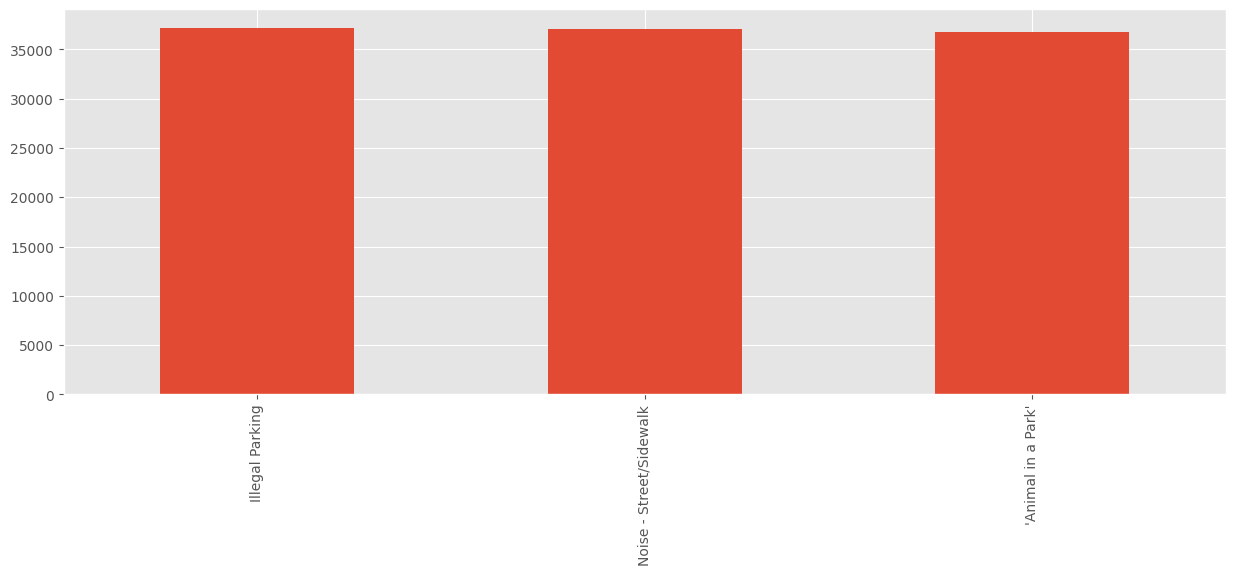

In [31]:
complaint_counts[:10].plot(kind='bar')

## Request real result

Now that we finished our analysis on the mock data, we can request this execution on the real data.

In [32]:
@sy.syft_function(input_policy=sy.ExactMatch(df=asset.pointer),
                  output_policy=sy.SingleExecutionExactOutput())
def get_counts(df):
    complaint_counts = df['Complaint Type'].value_counts()
    return complaint_counts[:10]

Syft function 'get_counts' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.


Create and submit project

In [33]:
new_project = sy.Project(
    name="Pandas chapter 2",
    description="Hi, I would like to plot the histogram of the complaint types.",
    members=[guest_domain_client],
)
new_project

syft.service.project.project.ProjectSubmit

In [34]:
project = new_project.start()
assert isinstance(project, sy.service.project.project.Project)
project

syft.service.project.project.Project

In [35]:
project.create_code_request(get_counts, guest_domain_client)

<class 'syft.service.response.SyftSuccess'>: Code request for 'get_counts' successfully added to 'Pandas chapter 2' Project. To see code requests by a client, run `[your_client].code`

In [36]:
assert len(guest_domain_client.code.get_all())==1

In [37]:
assert len(project.events) == 1

In [38]:
assert isinstance(project.events[0], sy.service.project.project.ProjectRequest)

# Data owner: execute function

In [39]:
domain_client = node.client.login(email="info@openmined.org", password="changethis")

Logged into pandas-test-domain-2 as <info@openmined.org>


# Get messages

In [40]:
messages = domain_client.api.services.messages.get_all_unread()

In [41]:
messages

[syft.service.message.messages.Message, syft.service.message.messages.Message]

In [42]:
project_message = [x for x in messages if issubclass(x.linked_obj.object_type, Project)][0]

In [43]:
request = project_message.link.events[0].request
func = request.changes[0].link
op = func.output_policy_type

In [44]:
func

```python
class UserCode
    id: str = f03c76c7faa242b6a451767eb2865e78
    status.approved: str = False
    service_func_name: str = get_counts
    code:

@sy.syft_function(input_policy=sy.ExactMatch(df=asset.pointer),
                  output_policy=sy.SingleExecutionExactOutput())
def get_counts(df):
    complaint_counts = df['Complaint Type'].value_counts()
    return complaint_counts[:10]

```

In [45]:
get_counts_user_func = func.unsafe_function

In [46]:
real_data = domain_client.datasets[0].assets[0].data

In [47]:
real_result = get_counts_user_func(df=real_data)

In [48]:
real_result[:3]

HEATING                   14200
GENERAL CONSTRUCTION       7471
Street Light Condition     7117
Name: Complaint Type, dtype: int64

In [49]:
result = request.accept_by_depositing_result(real_result)
result
assert isinstance(result, sy.SyftSuccess)

# Data scientist: fetch result

In [50]:
asset = guest_client.datasets[0].assets[0]

In [51]:
guest_client.code[0].status

{NodeView(node_name='pandas-test-domain-2', verify_key=220533b9cfd19c40634c2c16c7dae108d4f6cc5281f61b0462c366b3e28321e8): <UserCodeStatus.EXECUTE: 'execute'>}

<Axes: >

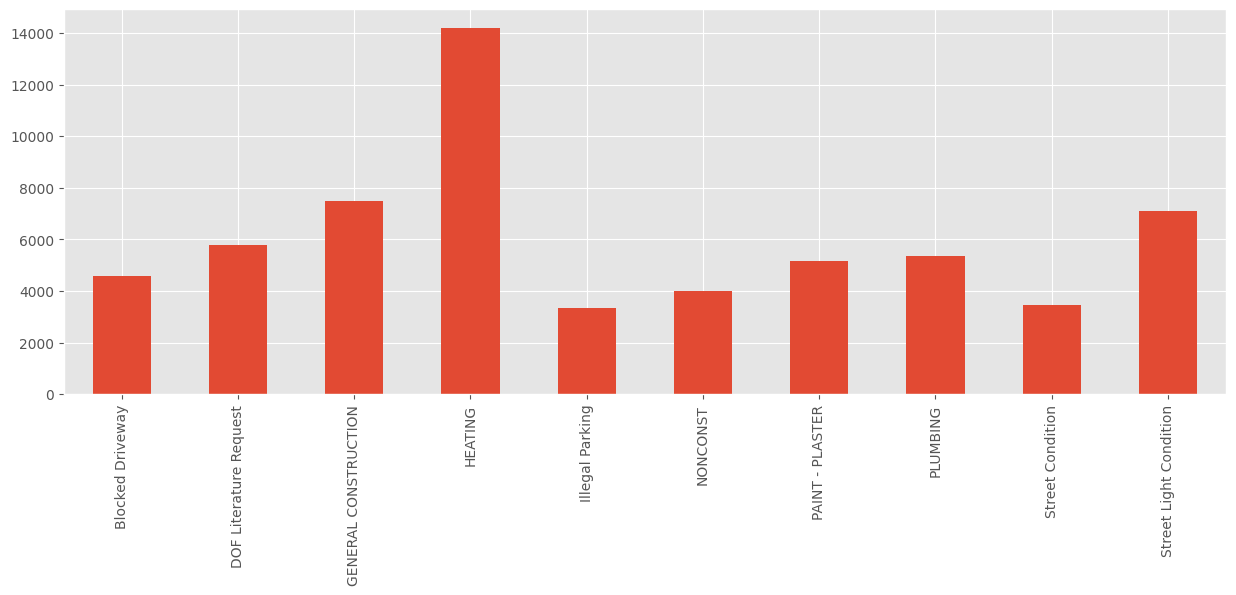

In [52]:
result_ptr = guest_client.code.get_counts(df=asset)
real_result = result_ptr.get()
real_result.plot(kind="bar")

In [53]:
node.land()

Stopping pandas-test-domain-2
